In [3]:
#### Cat vs. Dog Image Classification
#### Feature Extraction and Fine-Tuning
#### Feature Extraction Using a Pretrained Model
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [5]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [9]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
100/100 - 118s - loss: 0.3316 - acc: 0.8740 - val_loss: 0.1003 - val_acc: 0.9620
Epoch 2/2
100/100 - 101s - loss: 0.1896 - acc: 0.9260 - val_loss: 0.1299 - val_acc: 0.9570


In [ ]:
#### Further Improving Accuracy with Fine-Tuning

from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 105s - loss: 0.2362 - acc: 0.8985 - val_loss: 0.1295 - val_acc: 0.9440
Epoch 2/50
100/100 - 104s - loss: 0.2056 - acc: 0.9170 - val_loss: 0.1358 - val_acc: 0.9460
Epoch 3/50
100/100 - 103s - loss: 0.2279 - acc: 0.9070 - val_loss: 0.1477 - val_acc: 0.9380
Epoch 4/50
100/100 - 91s - loss: 0.2088 - acc: 0.9105 - val_loss: 0.1463 - val_acc: 0.9410
Epoch 5/50
100/100 - 93s - loss: 0.2275 - acc: 0.9090 - val_loss: 0.1360 - val_acc: 0.9480
Epoch 6/50
100/100 - 79s - loss: 0.2217 - acc: 0.9050 - val_loss: 0.1464 - val_acc: 0.9400
Epoch 7/50
100/100 - 82s - loss: 0.2131 - acc: 0.9125 - val_loss: 0.1432 - val_acc: 0.9410
Epoch 8/50
100/100 - 77s - loss: 0.2004 - acc: 0.9210 - val_loss: 0.1391 - val_acc: 0.9450
Epoch 9/50
100/100 - 76s - loss: 0.2306 - acc: 0.9080 - val_loss: 0.1416 - val_acc: 0.9430
Epoch 10/50
100/100 - 75s - loss: 0.2285 - acc: 0.9050 - val_loss: 0.1416 - val_acc: 0.9390
Epoch 11/50
100/100 - 75s - loss: 0.2138 - acc: 0.9205 - val_loss: 0.1211 - val_acc: 0

Text(0.5, 1.0, 'Training and validation loss')

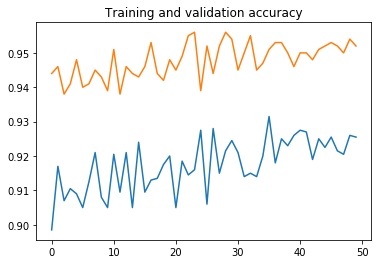

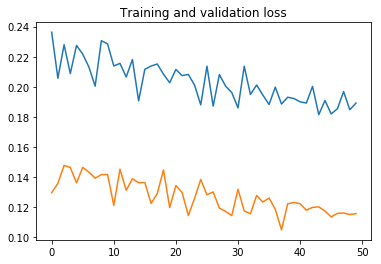

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
#### Clean Up
import os, signal
os.kill(os.getpid(), signal.SIGKILL)